In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
import phoenix

# System Parameters
grid_size = 600                 # Grid Size, int this case 600x600
x_max = 60                      # mum; Maximum Distance in one direction, meaning the grid will be from -60mum to 60mum
effective_mass = 5.684E-4       # kg; Effective Mass of the electron, scaled
gamma_c = 0.005                 # Polariton Loss Rate
gamma_r = 0                     # Reservoir Loss Rate
R = 0                           # Condensation Rate
g_c = 2E-6                      # Polariton-Polariton Coupling
g_r = 0                         # Polariton-Reservoir Coupling
t_step = 0.006                  # ps; Time step of the simulation

# Pump Parameters
pump_amplitude = 5.6856e-6              # eV; Pump Amplitude
pump_frequency = -5.68828730684262      # Hz; Pump Frequency

# Additional Parameters not required by PHOENIX:
hbar = 6.582119569E-4
dx = x_max/grid_size

# Matrix Generation

While PHOENIX can also generate spacial shapes via its envelope syntax, it is usually beneficial to pre-generate all required inputs. This way, we can plot and verify the inputs beforehand.

We generate an X-Y Meshgrid using numpy, fill the pump and potential matrices and plot them.


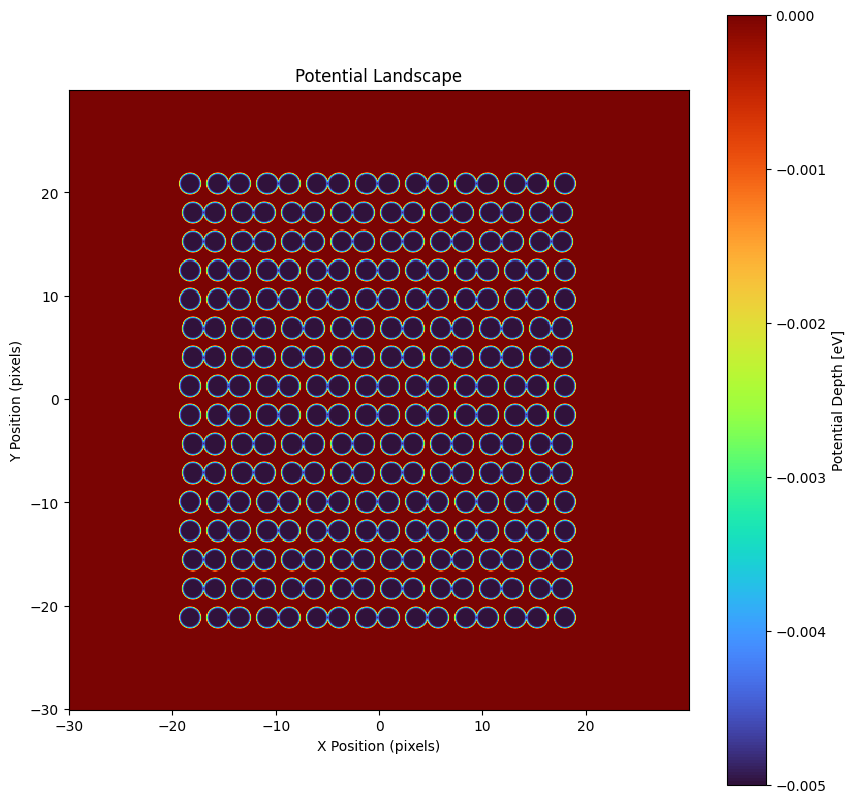

In [2]:
# Field resolution
vdxy = dx
vNx = grid_size
vNy = grid_size

# Geometric parameters (all distances from center point to center point)
vNw = 16   # Number of pillars in width/x direction
vNh = 16   # Number of pillars in height/y direction
va = 2.8   # Neighbor distance in x/w direction
vA = 2     # Distance between sub-lattices in y/h direction (between closest neighbors)
vd = 0.2   # Amplitude of the wave shift
vw = 2.15  # Width of the pillars
vV0 = 5e-3    # Depth of the pillars (here in meV)
vshift = 3.5  # Geometrical phase shift in pi/2

vnGauss = 20  # Gauss "steepness"

# Scale geometric parameters to resolution
va = va / vdxy
vA = vA / vdxy
vd = vd / vdxy
vw = vw / vdxy

# Some helper variables
vdeltay = vA + vd * 2  # Y mirror distance between sub-lattices (between sub-lattice centers)

vxoffset = vNx / 2 - ((vNw - 1) * va) / 2
vyoffset = vNy / 2 - ((vNh - 1) * vdeltay) / 2

vMatrix = np.zeros((vNx, vNy))  # Output matrix

vGaussSize = 2 * vw  # To reduce the number of iterations in the x and y loops

for i in range(1, vNw + 1):
    vwavedelta = vd * np.cos((i + vshift) * np.pi / 2)

    for j in range(1, vNh + 1):
        vwavedelta = -vwavedelta  # Mirror wave delta for every other sub-lattice

        vxcenter = vxoffset + (i - 1) * va
        vycenter = vyoffset + (j - 1) * vdeltay + vwavedelta

        x_start = max(1, int(round(vxcenter - vGaussSize)))
        x_end = min(vNx, int(round(vxcenter + vGaussSize)))
        y_start = max(1, int(round(vycenter - vGaussSize)))
        y_end = min(vNy, int(round(vycenter + vGaussSize)))

        for x in range(x_start, x_end + 1):
            for y in range(y_start, y_end + 1):
                # Adjust indices for zero-based indexing in Python
                x_idx = x - 1
                y_idx = y - 1
                exponent = -(((x - vxcenter) ** 2 + (y - vycenter) ** 2) ** (vnGauss / 2)) / ((vw / 2) ** vnGauss)
                vMatrix[x_idx, y_idx] += -vV0 * np.exp(exponent)

# X-Y Meshgrid
x = np.linspace(-x_max/2, x_max/2, grid_size, endpoint=False)
y = np.linspace(-x_max/2, x_max/2, grid_size, endpoint=False)
X, Y = np.meshgrid(x, y)

# Visualize the matrix
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal', 'box')
plt.pcolor(X,Y,vMatrix, cmap='turbo')
plt.colorbar(label='Potential Depth [eV]')
plt.title('Potential Landscape')
plt.xlabel('X Position (pixels)')
plt.ylabel('Y Position (pixels)')
plt.show()


# Helper Function to save the numpy matrices into a format PHOENIX can read
def save_matrix(matrix, filename):
    header = f"SIZE {grid_size} {grid_size} {x_max} {x_max} {dx} {dx} PYTHON-GENERATED"
    # if real matrix
    if np.isrealobj(matrix):
        np.savetxt( filename, matrix, header=header, fmt='%.5f' )
    else:
        np.savetxt( filename, matrix.real, header=header, fmt='%.5f' )

# Save the potential matrix
save_matrix(vMatrix, "potential.txt")

# Run Simulation with PHOENIX

We also plot the test calculation. The density for the given set of parameters should approach zero.

In [4]:
# define simulation parameters with a dict
# 
config={"N":[grid_size,grid_size],"L":[x_max,x_max],"meff":effective_mass,"hbarscaled":hbar,"tmax":5000,"tstep":t_step,"outEvery":1,"fftEvery":1e5,"gc":g_c,"gr":g_r,"R":R,"gammaR":gamma_r,"gammaC":gamma_c}
# Add constant resonant pump with oscillation
config["pulse"]=[pump_amplitude,"add",1e12,1e12,0,0,"plus",1,0,"gauss+noDivide","time","iexp",0,1E12,pump_frequency]
# Set random initial state
config["initRandom"]=[0.1,"random"]
# Add the potential
config["potential"]=["load potential.txt",1,"add plus"]
# Set output
config["output"]="wavefunction,max"

ph=phoenix.phoenix(debug=False,precision="fp64")
ph.run(config)

    T = 4989ps - dt = 0.006ps
    Progress: [▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇]  99%   
    Current System: Scalar - No Stochastic
    Runtime: 358s, remaining: 0s
    Time per ps: 0.072s/ps-  13.9ps/s-  2.33e+03it/s


### Plotting
PHOENIX saves outputs using one row per line, saving real parts first. This means, for our NxN complex matrices, PHOENIX will output a textfile containing a 2NxN (rows,cols) matrix. When loading the real and imaginary parts of the result, we can also calculate the phase using `np.angle`.

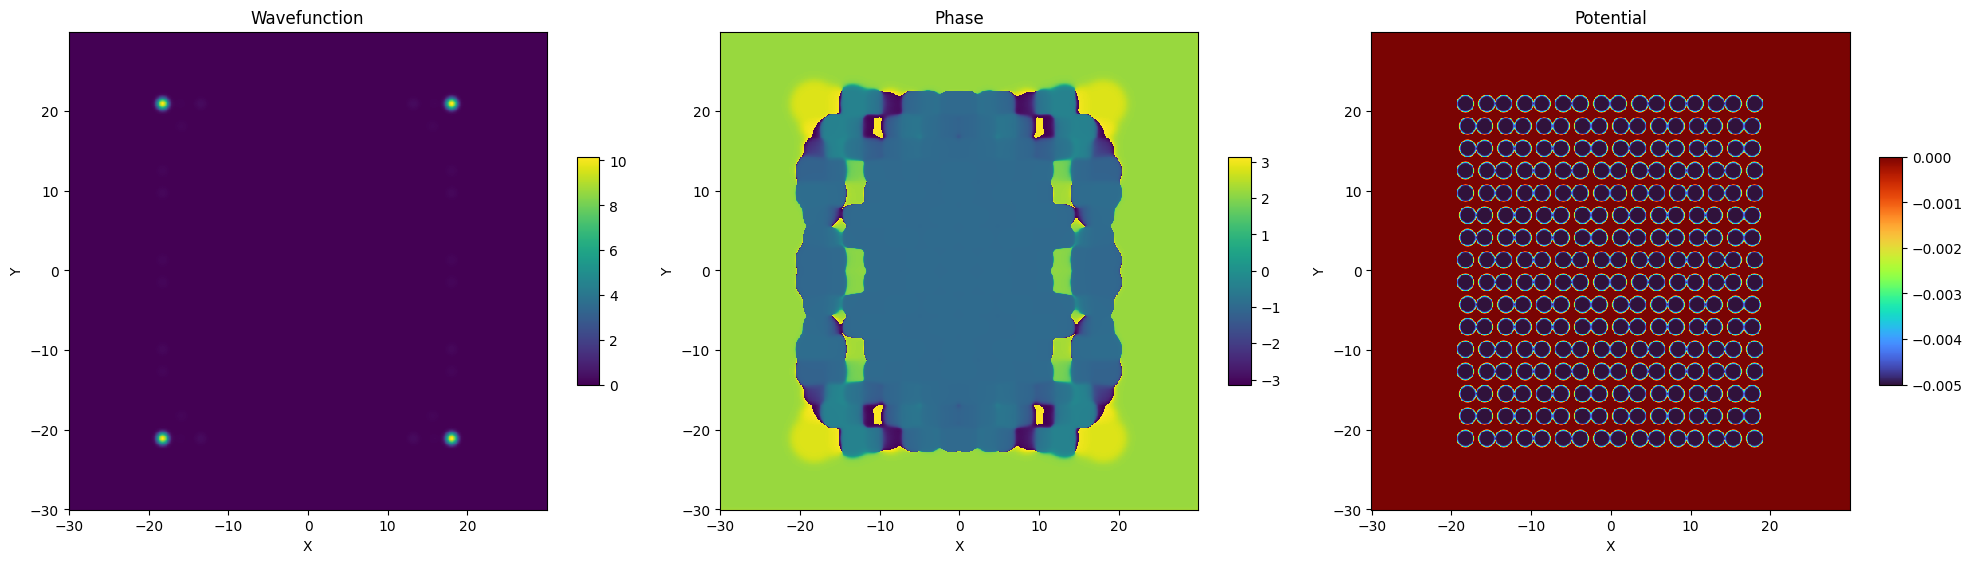

In [7]:
# Plot Results
data = np.loadtxt( os.path.join(ph.get_result_path(), "wavefunction_plus.txt") )
re,im = data[:grid_size,:], data[grid_size:,:]
psi = (re + 1j*im).reshape(grid_size,grid_size)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,6))
ax1.set_title("Wavefunction")

plt_psi = ax1.pcolormesh(X,Y,np.abs(psi)**2)
ax2.set_title("Phase")
plt_phase = ax2.pcolormesh(X,Y,np.angle(psi))

data = np.loadtxt("potential.txt")

ax3.set_title("Potential")
plt_potential = ax3.pcolormesh(X,Y,data, cmap='turbo')

for ax,plot in zip((ax1,ax2,ax3),(plt_psi,plt_phase,plt_potential)):
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect("equal")
    fig.colorbar(plot, ax=ax, shrink=0.4, aspect=10)

plt.tight_layout()

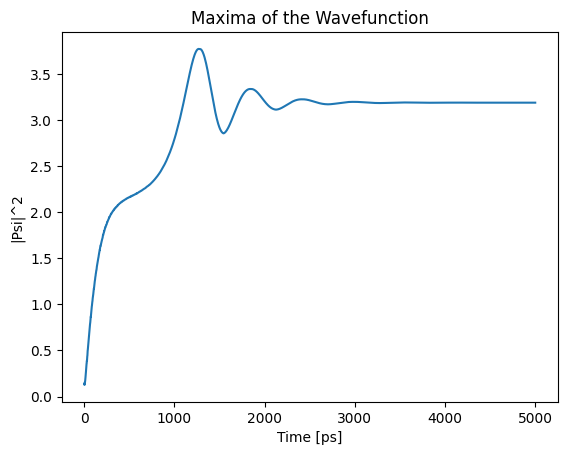

In [8]:
data_max = np.loadtxt( os.path.join(ph.get_result_path(), "scalar.txt"), unpack=True, comments="index" )

fig, ax = plt.subplots()
ax.set_title("Maxima of the Wavefunction")
ax.set_xlabel("Time [ps]")
ax.set_ylabel("|Psi|^2")
ax.plot(data_max[-1], data_max[1])

# (Optional) Calculate Eigenstates

In [ ]:
# Plot the first 5 Eigenstates
rows = N_eigs//5 + 1 if N_eigs%5 != 0 else N_eigs//5
cols = np.min((5, N_eigs)).astype(int)
fig, axes = plt.subplots(rows,cols, figsize=(20,4*rows))
ax = axes.flatten()
for i in range(N_eigs):
    ax[i].imshow(np.abs(eigenvectors[:,i]).reshape(grid_size,grid_size), cmap='turbo')
    ax[i].set_title(f"Eigenstate {i+1}\nE = {eigenvalues[i]:.8f} eV = {eigenvalues[i]/hbar:.8f} Hz",fontsize=8)
plt.tight_layout()
plt.show()

# Plot Eigenvalues
plt.figure()
plt.plot(eigenvalues, 'o')
plt.title("Eigenvalues")

In [4]:

from scipy.sparse import csc_matrix, linalg

def generate_hamiltonian(N: int = grid_size):
    dy = dx
    rows,cols,data = list(),list(),list()
    meff_scaled = -hbar**2/(2*effective_mass)
    # sparse matrix hamiltonian of size grid_size*grid_size x grid_size*grid_size
    for i in range(N):
        for j in range(N):
            idx = i*N + j
            # left,right neighbours
            if idx-1 > 0:
                d = meff_scaled/(dx**2)
                rows.append(idx)
                cols.append(idx-1)
                data.append(d)
            if idx+1 < N*N:
                d = meff_scaled/(dx**2)
                rows.append(idx)
                cols.append(idx+1)
                data.append(d)
            ## top,bottom neighbours
            if idx-N >= 0:
                d = meff_scaled/(dy**2)
                rows.append(idx-N)
                cols.append(idx)
                data.append(d)
            if idx+N < N*N:
                d = meff_scaled/(dy**2)
                rows.append(idx+N)
                cols.append(idx)
                data.append(d)

            # Nabla squared
            d = -2*meff_scaled/(dx**2) - 2*meff_scaled/(dy**2)
            # Potential
            d += vMatrix[i,j]
            rows.append(idx)
            cols.append(idx)
            data.append(d)
    hamiltonian = csc_matrix((data, (rows, cols)), shape=(N*N, N*N))
    return hamiltonian

h = generate_hamiltonian()

# Calculate Eigenvalues and Eigenvectors using numpy
#eigenvalues, eigenvectors = np.linalg.eigh(h.toarray())
N_eigs = 150
eigenvalues, eigenvectors = linalg.eigsh(h, k=N_eigs, which='SA', maxiter = 10000, tol=1e-8)

KeyboardInterrupt: 